## Diffusion demo

En este cuaderno se presenta una demostración práctica del uso de los distintos modelos de difusión desarrollados en el proyecto.

### Librerias ###

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

from functools import partial

import torch
from torch.utils.data import (
    DataLoader,
    Subset,
)
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.transforms import functional

from noise_schedules import LinearSchedule, CosineSchedule
from torchvision import transforms
from utils.data_loader import load_dataset

from utils import (
    plot_image_grid,
    load_dataset,
    plot_image_evolution_color,
    sample_initial_latents,
)

from samplers import predictor_corrector_integrator
from diffusion import VPProcess, VEProcess, SubVPProcess


n_threads = torch.get_num_threads()
print('Number of threads: {:d}'.format(n_threads))

device ='cuda'

Number of threads: 12


### Carga de datos

In [2]:
def colorize_grayscale(tensor_img):
    if tensor_img.shape[0] == 1:
        r, g, b = [torch.rand(1).item() for _ in range(3)]
        return torch.cat([tensor_img * r, tensor_img * g, tensor_img * b], dim=0)
    return tensor_img

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(colorize_grayscale),
])

data= load_dataset("mnist", transform=transform, return_loader=False)

In [3]:
# Create a subset dataset composed of only images of one of the digits
digit = 3
indices_digit = torch.where(data.targets == digit)[0]

data_train = Subset(data, indices_digit)

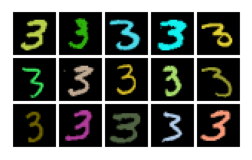

In [4]:
# Visualize training images
n_rows = 3
n_cols = 5

_ = plot_image_grid(
    images=[data_train[i][0] for i in range(n_rows * n_cols)],
    figsize =(3, 3),
    n_rows=n_rows,
    n_cols=n_cols,
)

## Variance Exploiding

In [5]:
sigma = 25.0
diffusion_process = VEProcess(
    sigma=sigma
)

In [6]:
from score_models import ScoreNet
from torch.optim import Adam
from tqdm.notebook import trange

# Crear el score model usando el sigma_t del VEProcess
score_model = torch.nn.DataParallel(
    ScoreNet(marginal_prob_std=diffusion_process.sigma_t, in_channels=3)

)
score_model = score_model.to(device)

batch_size = 32

data_loader = DataLoader(
    data_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_threads,
)

learning_rate = 1.0e-3
optimizer = Adam(score_model.parameters(), lr=learning_rate)

n_epochs =  30
tqdm_epoch = trange(n_epochs)

for epoch in tqdm_epoch:
    avg_loss = 0.0
    num_items = 0
    for x, y in data_loader:
        x = x.to(device)
        y = y.to(device)
        loss = diffusion_process.loss_function(score_model, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]

    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))

    torch.save(score_model.state_dict(), 'check_point.pth')

  0%|          | 0/30 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 3.81 GiB of which 3.12 MiB is free. Process 29216 has 3.69 GiB memory in use. Including non-PyTorch memory, this process has 118.00 MiB memory in use. Of the allocated memory 34.20 MiB is allocated by PyTorch, and 13.80 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
n_images = 5

diffusion_coefficient = diffusion_process.diffusion_coefficient

T = 1.0 - 1e-3
T_tensor = torch.tensor([T], device=device)
variance = diffusion_process.sigma_t(T_tensor) ** 2

image_T = sample_initial_latents(
    n_images=n_images,
    image_shape=(3, 28, 28),
    mean=0.0,
    std=variance,
    device=torch.device("cuda")
)

with torch.no_grad():
    times, synthetic_images_t = predictor_corrector_integrator(
        image_T,
        t_0=T,
        t_end= 1e-3,
        n_steps= 2000,
        drift_coefficient=lambda x_t, t: diffusion_process.reverse_drift(x_t, t, score_model),
        diffusion_coefficient=diffusion_coefficient,
        score_function=score_model,
        n_corrector_steps=5,
        corrector_step_size=0.0001
   )

In [ ]:
_ = plot_image_evolution_color(
    images=synthetic_images_t.cpu(),
    n_images=n_images,
    n_intermediate_steps=[0, 5, 200, 300, 400, 450, 470, 480, 490, 500, 1000,1500, 1800, 2000],
    figsize=(10, 10),
)

## Variance Preserve with linear noise

In [ ]:
# Crear el noise schedule lineal
schedule = LinearSchedule(beta_min=0.01, beta_max=5.0)

# Instanciar el proceso de difusión Variance Preserving con Linear
diffusion_process= VPProcess(noise_schedule=schedule)

In [ ]:
# Crear el score model usando el sigma_t del VEProcess
score_model = torch.nn.DataParallel(
    ScoreNet(marginal_prob_std=diffusion_process.sigma_t, in_channels=3)

)
score_model = score_model.to(device)

batch_size = 32

data_loader = DataLoader(
    data_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_threads,
)

learning_rate = 1.0e-3
optimizer = Adam(score_model.parameters(), lr=learning_rate)

n_epochs =  30
tqdm_epoch = trange(n_epochs)

for epoch in tqdm_epoch:
    avg_loss = 0.0
    num_items = 0
    for x, y in data_loader:
        x = x.to(device)
        y = y.to(device)
        loss = diffusion_process.loss_function(score_model, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]

    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))


In [ ]:
n_images = 5

diffusion_coefficient = diffusion_process.diffusion_coefficient

T = 1.0 - 1e-3
T_tensor = torch.tensor([T], device=device)
variance = diffusion_process.sigma_t(T_tensor) ** 2

image_T = sample_initial_latents(
    n_images=n_images,
    image_shape=(3, 28, 28),
    mean=0.0,
    std=variance,
    device=torch.device("cuda")
)

with torch.no_grad():
    times, synthetic_images_t = predictor_corrector_integrator(
        image_T,
        t_0=T,
        t_end= 1e-3,
        n_steps= 2000,
        drift_coefficient=lambda x_t, t: diffusion_process.reverse_drift(x_t, t, score_model),
        diffusion_coefficient=diffusion_coefficient,
        score_function=score_model,
        n_corrector_steps=5,
        corrector_step_size=0.0001
   )

In [ ]:
_ = plot_image_evolution_color(
    images=synthetic_images_t.cpu(),
    n_images=n_images,
    n_intermediate_steps=[0, 5, 200, 300, 400, 450, 470, 480, 490, 500, 1000,1500, 1800, 2000],
    figsize=(10, 10),
)

## Variance Preserve with cosine noise

In [ ]:
# Crear el noise schedule lineal
schedule = CosineSchedule(s=0.008)

# Instanciar el proceso de difusión Variance Preserving con Linear
diffusion_process= VPProcess(noise_schedule=schedule)

In [ ]:
# Crear el score model usando el sigma_t del VEProcess
score_model = torch.nn.DataParallel(
    ScoreNet(marginal_prob_std=diffusion_process.sigma_t, in_channels=3)

)
score_model = score_model.to(device)

batch_size = 32

data_loader = DataLoader(
    data_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_threads,
)

learning_rate = 1.0e-3
optimizer = Adam(score_model.parameters(), lr=learning_rate)

n_epochs =  30
tqdm_epoch = trange(n_epochs)

for epoch in tqdm_epoch:
    avg_loss = 0.0
    num_items = 0
    for x, y in data_loader:
        x = x.to(device)
        y = y.to(device)
        loss = diffusion_process.loss_function(score_model, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]

    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))


In [ ]:
n_images = 5

diffusion_coefficient = diffusion_process.diffusion_coefficient

T = 1.0 - 1e-3
T_tensor = torch.tensor([T], device=device)
variance = diffusion_process.sigma_t(T_tensor) ** 2

image_T = sample_initial_latents(
    n_images=n_images,
    image_shape=(3, 28, 28),
    mean=0.0,
    std=variance,
    device=torch.device("cuda")
)

with torch.no_grad():
    times, synthetic_images_t = predictor_corrector_integrator(
        image_T,
        t_0=T,
        t_end= 1e-3,
        n_steps= 2000,
        drift_coefficient=lambda x_t, t: diffusion_process.reverse_drift(x_t, t, score_model),
        diffusion_coefficient=diffusion_coefficient,
        score_function=score_model,
        n_corrector_steps=5,
        corrector_step_size=0.0001
   )

In [ ]:
_ = plot_image_evolution_color(
    images=synthetic_images_t.cpu(),
    n_images=n_images,
    n_intermediate_steps=[0, 5, 200, 300, 400, 450, 470, 480, 490, 500, 1000,1500, 1800, 2000],
    figsize=(10, 10),
)

## SubVariance Preserve with cosine noise

In [ ]:
# Crear el noise schedule lineal
schedule = CosineSchedule(s=0.008)

# Instanciar el proceso de difusión Variance Preserving con Linear
diffusion_process= SubVPProcess(noise_schedule=schedule)

In [ ]:
# Crear el score model usando el sigma_t del VEProcess
score_model = torch.nn.DataParallel(
    ScoreNet(marginal_prob_std=diffusion_process.sigma_t, in_channels=3)

)
score_model = score_model.to(device)

batch_size = 32

data_loader = DataLoader(
    data_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_threads,
)

learning_rate = 1.0e-3
optimizer = Adam(score_model.parameters(), lr=learning_rate)

n_epochs =  30
tqdm_epoch = trange(n_epochs)

for epoch in tqdm_epoch:
    avg_loss = 0.0
    num_items = 0
    for x, y in data_loader:
        x = x.to(device)
        y = y.to(device)
        loss = diffusion_process.loss_function(score_model, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]

    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))


In [ ]:
n_images = 5

diffusion_coefficient = diffusion_process.diffusion_coefficient

T = 1.0 - 1e-3
T_tensor = torch.tensor([T], device=device)
variance = diffusion_process.sigma_t(T_tensor) ** 2

image_T = sample_initial_latents(
    n_images=n_images,
    image_shape=(3, 28, 28),
    mean=0.0,
    std=variance,
    device=torch.device("cuda")
)

with torch.no_grad():
    times, synthetic_images_t = predictor_corrector_integrator(
        image_T,
        t_0=T,
        t_end= 1e-3,
        n_steps= 2000,
        drift_coefficient=lambda x_t, t: diffusion_process.reverse_drift(x_t, t, score_model),
        diffusion_coefficient=diffusion_coefficient,
        score_function=score_model,
        n_corrector_steps=5,
        corrector_step_size=0.0001
   )

In [ ]:
_ = plot_image_evolution_color(
    images=synthetic_images_t.cpu(),
    n_images=n_images,
    n_intermediate_steps=[0, 5, 200, 300, 400, 450, 470, 480, 490, 500, 1000,1500, 1800, 2000],
    figsize=(10, 10),
)

## SubVariance Preserve with linear noise

In [ ]:
# Crear el noise schedule lineal
schedule = LinearSchedule(beta_min=0.01, beta_max=5.0)

# Instanciar el proceso de difusión Variance Preserving con Linear
diffusion_process= SubVPProcess(noise_schedule=schedule)

In [ ]:
# Crear el score model usando el sigma_t del VEProcess
score_model = torch.nn.DataParallel(
    ScoreNet(marginal_prob_std=diffusion_process.sigma_t, in_channels=3)

)
score_model = score_model.to(device)

batch_size = 32

data_loader = DataLoader(
    data_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_threads,
)

learning_rate = 1.0e-3
optimizer = Adam(score_model.parameters(), lr=learning_rate)

n_epochs =  30
tqdm_epoch = trange(n_epochs)

for epoch in tqdm_epoch:
    avg_loss = 0.0
    num_items = 0
    for x, y in data_loader:
        x = x.to(device)
        y = y.to(device)
        loss = diffusion_process.loss_function(score_model, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]

    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))


In [ ]:
n_images = 5

diffusion_coefficient = diffusion_process.diffusion_coefficient

T = 1.0 - 1e-3
T_tensor = torch.tensor([T], device=device)
variance = diffusion_process.sigma_t(T_tensor) ** 2

image_T = sample_initial_latents(
    n_images=n_images,
    image_shape=(3, 28, 28),
    mean=0.0,
    std=variance,
    device=torch.device("cuda")
)

with torch.no_grad():
    times, synthetic_images_t = predictor_corrector_integrator(
        image_T,
        t_0=T,
        t_end= 1e-3,
        n_steps= 2000,
        drift_coefficient=lambda x_t, t: diffusion_process.reverse_drift(x_t, t, score_model),
        diffusion_coefficient=diffusion_coefficient,
        score_function=score_model,
        n_corrector_steps=5,
        corrector_step_size=0.0001
   )

In [ ]:
_ = plot_image_evolution_color(
    images=synthetic_images_t.cpu(),
    n_images=n_images,
    n_intermediate_steps=[0, 5, 200, 300, 400, 450, 470, 480, 490, 500, 1000,1500, 1800, 2000],
    figsize=(10, 10),
)